# 02 — Modeling & Forecast

Fit SARIMAX, evaluate on a holdout set, and visualize forecast vs. actual.

In [41]:
#Imports & confi
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import joblib


RANDOM_STATE = 42
PROJECT_ROOT = Path().resolve().parents[0] if (Path().resolve().name == 'notebooks') else Path().resolve()
DATA_PATH = PROJECT_ROOT / 'data' / 'prepared_sales.csv'
MODEL_DIR = PROJECT_ROOT / 'src' / 'models'
MODEL_DIR.mkdir(parents=True, exist_ok=True)


print('DATA_PATH ->', DATA_PATH)

DATA_PATH -> /Users/sakshisingh/Downloads/ai_internship_projects/sales_forecasting/data/prepared_sales.csv


In [42]:
#Load prepared data
df = pd.read_csv(DATA_PATH, parse_dates=['Date']).set_index('Date')
print('Loaded:', df.shape)
df.head()

Loaded: (731, 3)


,Sales,Promo,Holiday
Date,,,
2023-01-01,93.51,0,0
2023-01-02,105.03,0,0
2023-01-03,100.94,0,0
2023-01-04,98.82,0,0
2023-01-05,95.07,0,0


In [43]:
#Feature engineering function
def make_features(df, lags=[1,7,14,28], rolling=[7,14,28]):
    df = df.copy()
# time features
    df['day'] = df.index.day
    df['weekday'] = df.index.weekday
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)


    # lags
    for lag in lags:
        df[f'lag_{lag}'] = df['Sales'].shift(lag)


    # rolling
    for w in rolling:
        df[f'roll_mean_{w}'] = df['Sales'].shift(1).rolling(w).mean()
        df[f'roll_std_{w}'] = df['Sales'].shift(1).rolling(w).std()

    df = df.dropna()
    return df


# create features
df_feat = make_features(df)
print('After features:', df_feat.shape)
df_feat.head()

After features: (703, 21)


,Sales,Promo,Holiday,day,weekday,month,quarter,year,dayofyear,is_month_start,...,lag_1,lag_7,lag_14,lag_28,roll_mean_7,roll_std_7,roll_mean_14,roll_std_14,roll_mean_28,roll_std_28
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-29,107.33,0,0,29,6,1,1,2023,29,0,...,99.78,116.03,105.08,93.51,114.355714,13.588924,111.201429,14.134302,106.458214,12.609925
2023-01-30,118.22,0,0,30,0,1,1,2023,30,0,...,107.33,122.44,108.79,105.03,113.112857,13.806386,111.362143,14.071998,106.951786,12.352175
2023-01-31,124.84,0,0,31,1,1,1,2023,31,0,...,118.22,111.16,129.84,100.94,112.510000,13.417905,112.035714,14.164792,107.422857,12.526452
2023-02-01,112.19,0,0,1,2,2,1,2023,32,1,...,124.84,128.10,126.03,98.82,114.464286,14.163996,111.678571,13.737956,108.276429,12.877706
2023-02-02,97.05,0,0,2,3,2,1,2023,33,0,...,112.19,128.98,99.90,95.07,112.191429,12.824399,110.690000,13.109377,108.753929,12.761431


In [44]:
#Train/test split

# Use last N days as test
TEST_DAYS = 90
train = df_feat.iloc[:-TEST_DAYS]
test = df_feat.iloc[-TEST_DAYS:]


X_train = train.drop(columns=['Sales'])
y_train = train['Sales']
X_test = test.drop(columns=['Sales'])
y_test = test['Sales']


print('X_train shape:', X_train.shape, 'X_test shape:', X_test.shape)

X_train shape: (613, 20) X_test shape: (90, 20)


In [45]:
#Baseline naive 

y_pred_naive = X_test['lag_1'].values
print('Baseline Naive MAE:', mean_absolute_error(y_test, y_pred_naive))
import numpy as np

mse = mean_squared_error(y_test, y_pred_naive)   # normal MSE
rmse = np.sqrt(mse)                             # take square root manually
print("Baseline Naive RMSE:", rmse)


Baseline Naive MAE: 13.603
Baseline Naive RMSE: 16.57055618324932


In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# train
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# predict
y_pred_rf = rf.predict(X_test)

# evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest MAE: {mae_rf:.3f}")
print(f"Random Forest RMSE: {rmse_rf:.3f}")


Random Forest MAE: 10.188
Random Forest RMSE: 13.107


In [47]:
from pathlib import Path

# Define and create images folder
IMG_DIR = Path("../images")
IMG_DIR.mkdir(parents=True, exist_ok=True)

print("Images will be saved to:", IMG_DIR.resolve())


Images will be saved to: /Users/sakshisingh/Downloads/ai_internship_projects/sales_forecasting/images


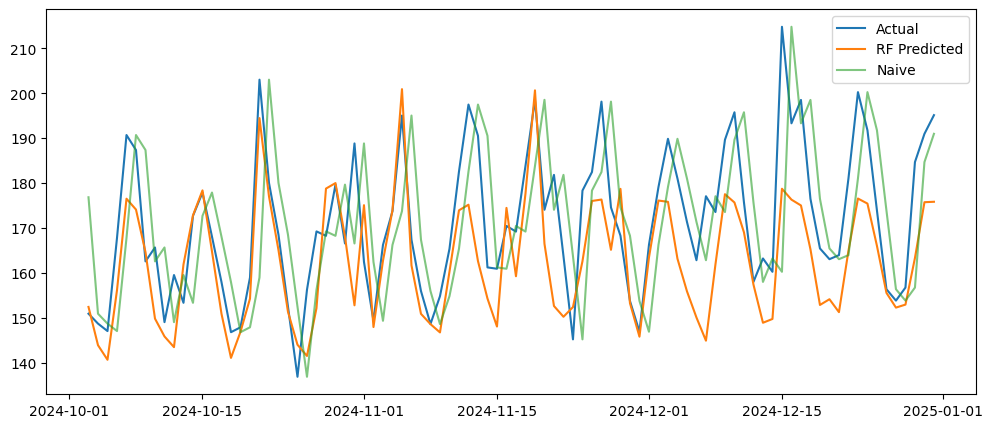

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_rf, label='RF Predicted')
plt.plot(y_test.index, X_test['lag_1'].values, label='Naive', alpha=0.6)
plt.legend()
plt.savefig(IMG_DIR / "actual_vs_predicted.png", dpi=300, bbox_inches="tight")
plt.show()



In [49]:
import pandas as pd

feat_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feat_imp.head(15))


roll_mean_28    0.257781
roll_mean_14    0.147151
lag_7           0.123706
weekday         0.092193
Promo           0.080794
lag_28          0.075137
roll_mean_7     0.059045
lag_14          0.054752
year            0.027442
lag_1           0.017512
roll_std_14     0.013093
dayofyear       0.012087
roll_std_7      0.010255
roll_std_28     0.010014
day             0.009690
dtype: float64


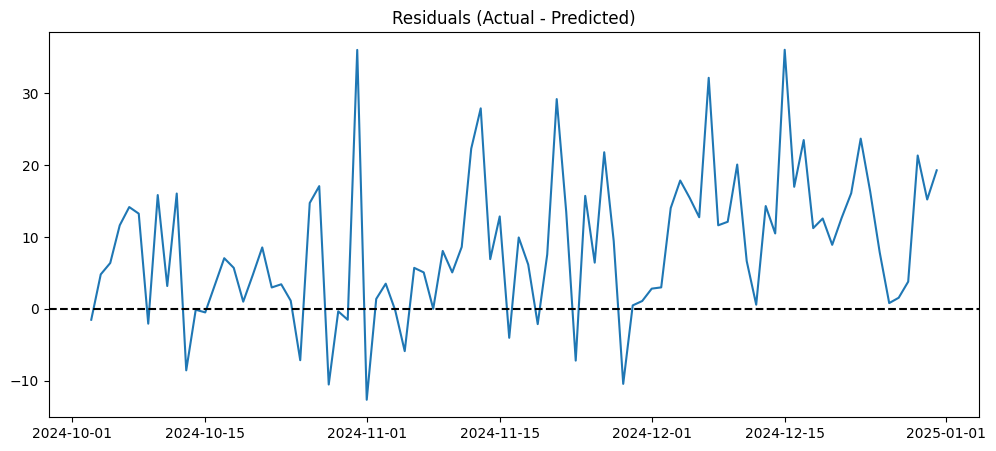

In [50]:
#Residual analysis 

residuals = y_test - y_pred_rf


plt.figure(figsize=(12,5))
plt.plot(residuals)
plt.axhline(0, color="black", linestyle="--")
plt.title("Residuals (Actual - Predicted)")
plt.savefig(IMG_DIR / "residuals.png", dpi=300, bbox_inches="tight")
plt.show()

In [51]:
#Error by weekday 

err_df = pd.DataFrame({'actual': y_test, 'pred': y_pred_rf})
err_df['error'] = (err_df['actual'] - err_df['pred']).abs()
err_df['weekday'] = err_df.index.weekday


print("Mean Absolute Error by Weekday:")
print(err_df.groupby('weekday')['error'].mean())

Mean Absolute Error by Weekday:
weekday
0     9.682996
1    12.495373
2     8.714021
3    10.976881
4     7.533300
5     9.165065
6    12.634431
Name: error, dtype: float64


XGB MAE: 13.537
XGB RMSE: 16.182


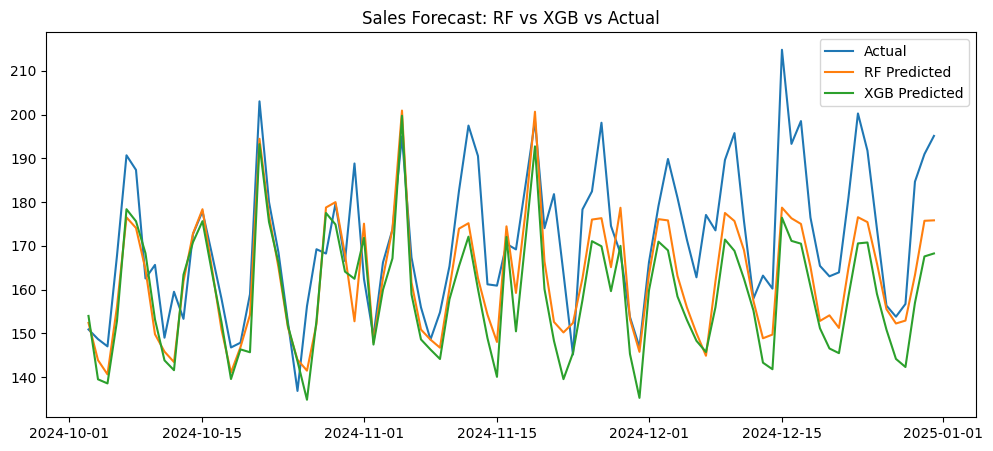

Saved XGB model to /Users/sakshisingh/Downloads/ai_internship_projects/sales_forecasting/src/models/xgb_sales_model.joblib


In [52]:
#Train XGBoost model

try:
    import xgboost as xgb
    xgbm = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
    )
    xgbm.fit(X_train, y_train)
    y_pred_xgb = xgbm.predict(X_test)
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    print(f"XGB MAE: {mae_xgb:.3f}")
    print(f"XGB RMSE: {rmse_xgb:.3f}")
    plt.figure(figsize=(12,5))
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, y_pred_rf, label='RF Predicted')
    plt.plot(y_test.index, y_pred_xgb, label='XGB Predicted')
    plt.legend()
    plt.title('Sales Forecast: RF vs XGB vs Actual')
    plt.savefig(IMG_DIR / "rf_vs_xgb_vs_actual.png", dpi=300, bbox_inches="tight")
    plt.show()
    # save xgb model
    joblib.dump(xgbm, MODEL_DIR / 'xgb_sales_model.joblib')
    print('Saved XGB model to', MODEL_DIR / 'xgb_sales_model.joblib')
except Exception as e:
    print('XGBoost not available or failed to run:', e)


In [53]:
#Quick performance summary
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("Naive MAE:", mean_absolute_error(y_test, y_pred_naive))
print("Naive RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_naive)))
print("RF   MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RF   RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
try:
    print("XGB  MAE:", mean_absolute_error(y_test, y_pred_xgb))
    print("XGB  RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
except NameError:
    print("XGB predictions not found.")


Naive MAE: 13.603
Naive RMSE: 16.57055618324932
RF   MAE: 10.187920555555532
RF   RMSE: 13.107244868942367
XGB  MAE: 13.537019042968748
XGB  RMSE: 16.182090223021756


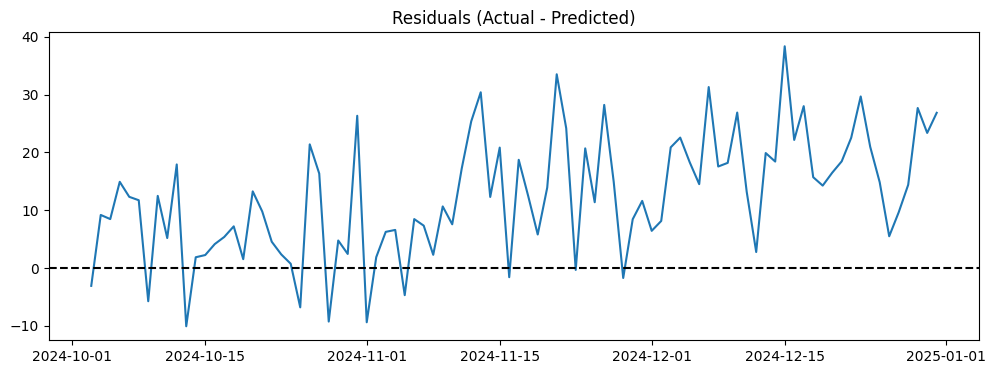

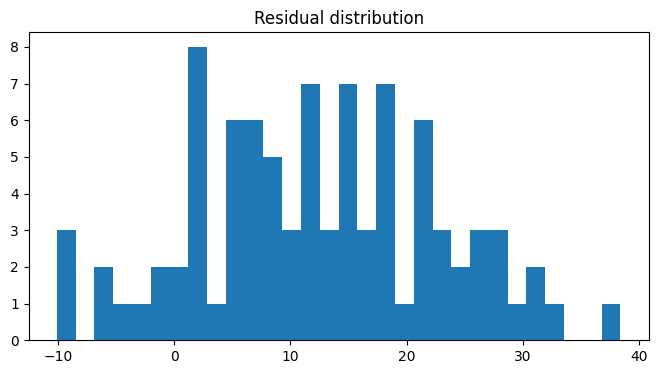

In [54]:
#Residual diagnostics
# residuals for best model (use XGB if available, else RF)
model_pred = y_pred_xgb if 'y_pred_xgb' in globals() else y_pred_rf
residuals = y_test - model_pred

plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.axhline(0, color='k', linestyle='--')
plt.title('Residuals (Actual - Predicted)')
plt.savefig(IMG_DIR / "residuals.png", dpi=300, bbox_inches="tight")
plt.show()

# distribution of residuals
plt.figure(figsize=(8,4))
plt.hist(residuals, bins=30)
plt.title('Residual distribution')
plt.savefig(IMG_DIR / "residual_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


In [55]:
#Error by weekday (to detect weekly pattern)

err_df = pd.DataFrame({'actual': y_test, 'pred': model_pred})
err_df['abs_error'] = (err_df['actual'] - err_df['pred']).abs()
err_df['weekday'] = err_df.index.weekday
err_by_wd = err_df.groupby('weekday')['abs_error'].mean()
print("Mean absolute error by weekday (0=Mon):")
print(err_by_wd)


Mean absolute error by weekday (0=Mon):
weekday
0    14.032932
1    16.231968
2    12.390595
3    11.055213
4    11.850414
5    12.152118
6    16.957706
Name: abs_error, dtype: float64


In [56]:
#Feature importance (XGBoost & RF)

import pandas as pd

# RF importance
rf_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("RF top features:")
print(rf_imp.head(15))

# XGB importance (if available)
if 'xgbm' in globals():
    try:
        xgb_imp = pd.Series(xgbm.feature_importances_, index=X_train.columns).sort_values(ascending=False)
        print("\nXGB top features:")
        print(xgb_imp.head(15))
    except Exception as e:
        print("Could not get XGB importances:", e)


RF top features:
roll_mean_28    0.257781
roll_mean_14    0.147151
lag_7           0.123706
weekday         0.092193
Promo           0.080794
lag_28          0.075137
roll_mean_7     0.059045
lag_14          0.054752
year            0.027442
lag_1           0.017512
roll_std_14     0.013093
dayofyear       0.012087
roll_std_7      0.010255
roll_std_28     0.010014
day             0.009690
dtype: float64

XGB top features:
roll_mean_14    0.357806
roll_mean_28    0.193452
Promo           0.142196
weekday         0.111990
lag_28          0.039456
Holiday         0.033406
lag_7           0.033072
lag_14          0.017164
roll_mean_7     0.011965
roll_std_14     0.011095
month           0.010542
dayofyear       0.010495
lag_1           0.008553
roll_std_28     0.007388
roll_std_7      0.006098
dtype: float32


In [57]:
#Quick hyperparameter tuning for XGB or RF — TimeSeriesSplit + RandomizedSearchCV

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

tscv = TimeSeriesSplit(n_splits=4)
param_dist = {
    'n_estimators': [100,200,400],
    'max_depth': [5,8,12, None],
    'min_samples_leaf': [1,2,4]
}

rsearch = RandomizedSearchCV(RandomForestRegressor(random_state=42),
                             param_distributions=param_dist,
                             n_iter=8,
                             cv=tscv,
                             scoring='neg_mean_absolute_error',
                             n_jobs=-1,
                             random_state=42)
# rsearch.fit(X_train, y_train)   # uncomment to run (can be slow)
# print("Best RF params:", rsearch.best_params_)
# best_rf = rsearch.best_estimator_
# joblib.dump(best_rf, MODEL_DIR / 'rf_tuned.joblib')


In [58]:
from pathlib import Path

OUT_DIR = Path("../data")
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("Output directory set to:", OUT_DIR)


Output directory set to: ../data


In [59]:
#Forecast the next N days (recursive forecasting)

# Robust recursive forecasting that fills missing feature columns with defaults (0)
N = 30  # days to forecast
history = df['Sales'].copy()  # full history (Series)
future_idx = pd.date_range(start=history.index.max() + pd.Timedelta(days=1), periods=N, freq='D')
future = pd.DataFrame(index=future_idx)

# Which features did model expect?
expected_cols = list(X_train.columns) if 'X_train' in globals() else (feature_cols if feature_cols is not None else list(X.columns))
print("Model expects columns:", expected_cols[:10], " ...", len(expected_cols), "total")

model_to_use = model  # xgbm or rf or hgb

preds = []
for d in future_idx:
    temp = pd.DataFrame(index=[d])
    # time features
    temp['day'] = d.day
    temp['weekday'] = d.weekday()
    temp['month'] = d.month
    temp['quarter'] = d.quarter
    temp['year'] = d.year
    temp['dayofyear'] = d.dayofyear
    temp['is_month_start'] = int(d.is_month_start)
    temp['is_month_end'] = int(d.is_month_end)

    # create lag features from history (use most recent values)
    for lag in [1,7,14,28]:
        if len(history) >= lag:
            temp[f'lag_{lag}'] = history.iloc[-lag]
        else:
            temp[f'lag_{lag}'] = history.iloc[-1]

    # rolling features (if not enough data, use last available)
    for w in [7,14,28]:
        roll_mean = history.shift(1).rolling(w).mean().iloc[-1] if len(history) >= w else history.mean()
        roll_std  = history.shift(1).rolling(w).std().iloc[-1] if len(history) >= w else history.std()
        temp[f'roll_mean_{w}'] = roll_mean
        temp[f'roll_std_{w}']  = roll_std

    # Ensure all expected columns exist in temp. If missing (e.g., Promo/Holiday),
    # create them and fill with 0 (or change default as required).
    for col in expected_cols:
        if col not in temp.columns:
            # choose a sensible default: 0 for numeric/time indicators, otherwise 0
            temp[col] = 0

    # Reorder columns to the expected order
    temp = temp.reindex(columns=expected_cols)

    # Final safety: fill any remaining NaN
    temp = temp.fillna(method='ffill', axis=1).fillna(0)

    # Predict and append
    yhat = model_to_use.predict(temp)[0]
    preds.append(yhat)
    history.loc[d] = yhat  # append forecast to history so next iteration can use it

future['forecast'] = preds
future.to_csv(OUT_DIR / 'future_forecast.csv')
print('Saved future forecast to', OUT_DIR / 'future_forecast.csv')
future.head()


Model expects columns: ['Promo', 'Holiday', 'day', 'weekday', 'month', 'quarter', 'year', 'dayofyear', 'is_month_start', 'is_month_end']  ... 20 total
Saved future forecast to ../data/future_forecast.csv


,forecast
2025-01-01,155.830826
2025-01-02,145.419693
2025-01-03,144.519745
2025-01-04,149.179398
2025-01-05,160.751831


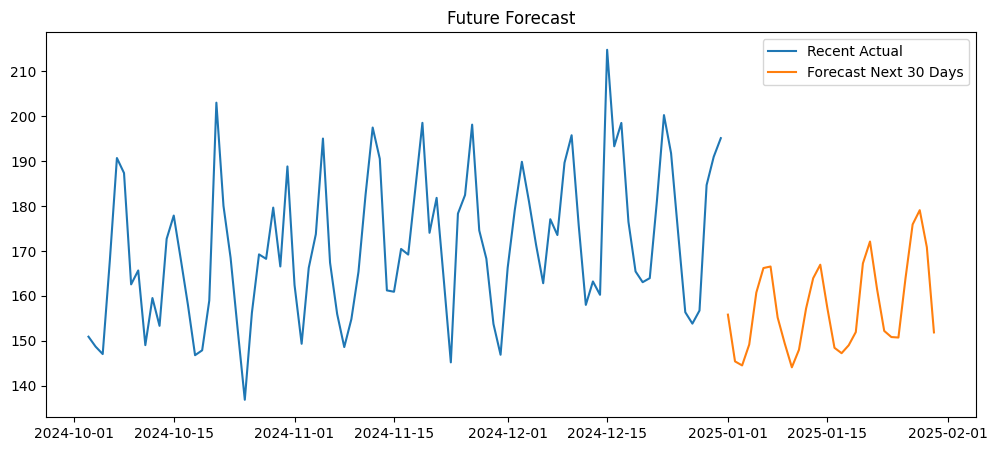

In [60]:
plt.figure(figsize=(12,5))
plt.plot(df.index[-90:], df['Sales'].iloc[-90:], label="Recent Actual")
plt.plot(future.index, future['forecast'], label="Forecast Next 30 Days")
plt.legend()
plt.title("Future Forecast")
plt.savefig(IMG_DIR / "future_forecast.png", dpi=300, bbox_inches="tight")
plt.show()


In [61]:
# ---- Align X_test (and X/future) to model's expected features and predict safely ----
import numpy as np
import pandas as pd

# 1) Get model expected features (works for sklearn/XGBoost)
try:
    model_expected = list(model.get_booster().feature_names)  # xgboost
except Exception:
    try:
        model_expected = list(model.feature_importances_.argsort())  # fallback, not ideal
        model_expected = list(X.columns)  # fallback to X columns
    except Exception:
        model_expected = list(X.columns)

print("Model expects:", model_expected)

# 2) Ensure X (full features), X_test, and future have same columns
def ensure_cols(df_in, expected_cols, default=0):
    df = df_in.copy()
    for c in expected_cols:
        if c not in df.columns:
            df[c] = default
    # drop any extra columns not expected (safe for predict)
    extra = [c for c in df.columns if c not in expected_cols]
    if extra:
        df = df.drop(columns=extra)
    # reorder to expected order
    df = df.reindex(columns=expected_cols)
    return df

# Apply to X, X_test and future (if they exist)
X = ensure_cols(X, model_expected)
X_test = ensure_cols(X_test, model_expected)
if 'future' in globals():
    future_inputs = ensure_cols(future.drop(columns=[c for c in ['forecast','lower_1sigma','upper_1sigma','lower_2sigma','upper_2sigma'] if c in future.columns], errors='ignore'),
                                model_expected)
    # keep forecast column separately; don't overwrite
else:
    future_inputs = None

print("After alignment — X columns:", X.columns.tolist()[:6], "... total", len(X.columns))

# 3) Now safely predict on X_test
y_pred = model.predict(X_test)
results = X_test.copy()
results['actual'] = y_test
results['pred'] = y_pred

print("Predictions done. results shape:", results.shape)


Model expects: ['Promo', 'Holiday', 'day', 'weekday', 'month', 'quarter', 'year', 'dayofyear', 'is_month_start', 'is_month_end', 'lag_1', 'lag_7', 'lag_14', 'lag_28', 'roll_mean_7', 'roll_std_7', 'roll_mean_14', 'roll_std_14', 'roll_mean_28', 'roll_std_28']
After alignment — X columns: ['Promo', 'Holiday', 'day', 'weekday', 'month', 'quarter'] ... total 20
Predictions done. results shape: (90, 22)


results created with shape: (90, 22)
Residual std (sigma): 11.243507380507074
Saved forecast with intervals to: /Users/sakshisingh/Downloads/ai_internship_projects/sales_forecasting/data/future_forecast_with_intervals.csv


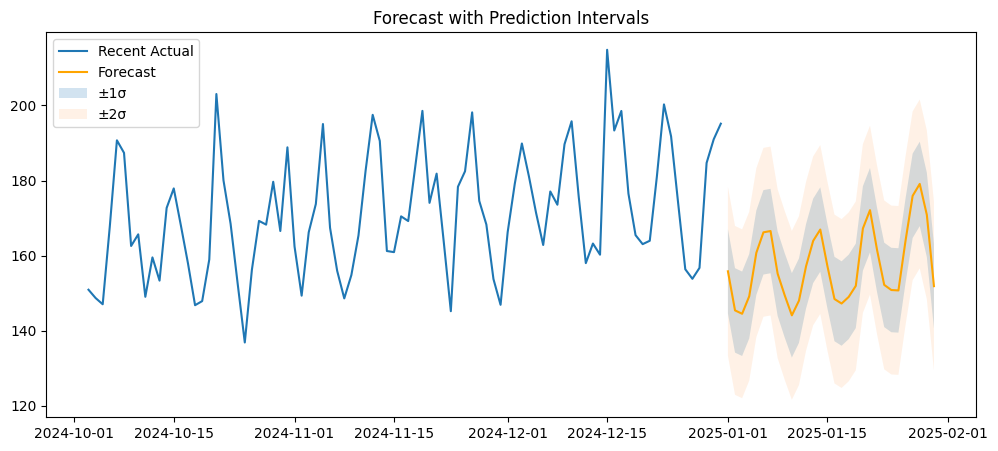

In [62]:
#Add prediction intervals (upper / lower bounds)

# --- Robust cell: recreate missing objects, compute prediction intervals, save & plot ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Helpers / paths ---
PROJECT_ROOT = Path().resolve().parents[0] if Path().resolve().name == 'notebooks' else Path().resolve()
DATA_DIR = PROJECT_ROOT / "data"
MODEL_DIR = PROJECT_ROOT / "src" / "models"
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR = DATA_DIR

# --- 1) Ensure prepared df is loaded ---
if 'df' not in globals():
    prepared_path = DATA_DIR / "prepared_sales.csv"
    if prepared_path.exists():
        df = pd.read_csv(prepared_path, parse_dates=['Date']).set_index('Date')
        print("Loaded prepared_sales.csv -> df")
    else:
        raise FileNotFoundError(f"{prepared_path} not found. Run data prep first.")

# --- 2) Recreate feature-building function (same as training) ---
def make_features_from_series(series, lags=[1,7,14,28], rolling=[7,14,28]):
    tmp = series.to_frame('Sales').copy()
    tmp.index = pd.to_datetime(tmp.index)
    tmp['day'] = tmp.index.day
    tmp['weekday'] = tmp.index.weekday
    tmp['month'] = tmp.index.month
    tmp['quarter'] = tmp.index.quarter
    tmp['year'] = tmp.index.year
    tmp['dayofyear'] = tmp.index.dayofyear
    tmp['is_month_start'] = tmp.index.is_month_start.astype(int)
    tmp['is_month_end'] = tmp.index.is_month_end.astype(int)
    for lag in lags:
        tmp[f'lag_{lag}'] = tmp['Sales'].shift(lag)
    for w in rolling:
        tmp[f'roll_mean_{w}'] = tmp['Sales'].shift(1).rolling(w).mean()
        tmp[f'roll_std_{w}']  = tmp['Sales'].shift(1).rolling(w).std()
    tmp = tmp.dropna()
    return tmp

# --- 3) Ensure features X and target y exist ---
if 'X' not in globals() or 'y' not in globals():
    df_feat = make_features_from_series(df['Sales'])
    X = df_feat.drop(columns=['Sales'])
    y = df_feat['Sales']
    print("Recreated X and y from df (features built).")

# --- 4) Ensure model is loaded ---
if 'model' not in globals():
    # try loading a saved model
    candidate_models = [
        MODEL_DIR / 'final_xgb_sales_model.joblib',
        MODEL_DIR / 'xgb_sales_model.joblib',
        MODEL_DIR / 'rf_sales_model.joblib',
        MODEL_DIR / 'hgb_sales_model.joblib'
    ]
    loaded = False
    for p in candidate_models:
        if p.exists():
            try:
                model = joblib.load(p)
                print("Loaded model from", p)
                loaded = True
                break
            except Exception as e:
                print("Failed to load", p, ":", e)
    if not loaded:
        raise FileNotFoundError("No saved model found in src/models. Run training notebook first.")

# --- 5) Recreate holdout results (results DataFrame) ---
TEST_DAYS = 90
if len(X) < TEST_DAYS:
    raise ValueError("Not enough data to create a holdout of TEST_DAYS.")

X_test = X.iloc[-TEST_DAYS:]
y_test = y.iloc[-TEST_DAYS:]
y_pred = model.predict(X_test)

results = X_test.copy()
results['actual'] = y_test
results['pred'] = y_pred
print("results created with shape:", results.shape)

# --- 6) Ensure 'future' forecast exists, else try to load saved future or create one via recursive method (simple) ---
if 'future' not in globals():
    # try to load precomputed future file
    fp = DATA_DIR / 'future_forecast.csv'
    if fp.exists():
        future = pd.read_csv(fp, parse_dates=['Unnamed: 0'], index_col=0)
        # if column named 'forecast' present, ok
        if 'forecast' not in future.columns and '0' in future.columns:
            future.columns = ['forecast']
        print("Loaded existing future forecast from", fp)
    else:
        # quick recursive forecast using same approach as earlier
        print("No precomputed future forecast found. Creating a 30-day recursive forecast now...")
        history = df['Sales'].copy()
        N = 30
        future_idx = pd.date_range(start=history.index.max() + pd.Timedelta(days=1), periods=N, freq='D')
        preds = []
        # expected cols (model input)
        expected_cols = list(X.columns)
        for d in future_idx:
            temp = pd.DataFrame(index=[d])
            temp['day'] = d.day
            temp['weekday'] = d.weekday()
            temp['month'] = d.month
            temp['quarter'] = d.quarter
            temp['year'] = d.year
            temp['dayofyear'] = d.dayofyear
            temp['is_month_start'] = int(d.is_month_start)
            temp['is_month_end'] = int(d.is_month_end)
            for lag in [1,7,14,28]:
                temp[f'lag_{lag}'] = history.iloc[-lag] if len(history) >= lag else history.iloc[-1]
            for w in [7,14,28]:
                temp[f'roll_mean_{w}'] = history.shift(1).rolling(w).mean().iloc[-1] if len(history) >= w else history.mean()
                temp[f'roll_std_{w}']  = history.shift(1).rolling(w).std().iloc[-1] if len(history) >= w else history.std()
            # fill any missing expected columns (Promo/Holiday etc) with 0
            for col in expected_cols:
                if col not in temp.columns:
                    temp[col] = 0
            temp = temp.reindex(columns=expected_cols).fillna(0)
            yhat = model.predict(temp)[0]
            preds.append(yhat)
            history.loc[d] = yhat
        future = pd.DataFrame(index=future_idx)
        future['forecast'] = preds
        future.to_csv(DATA_DIR / 'future_forecast.csv')
        print("Created and saved new future_forecast.csv")

# --- 7) Compute residual std and add prediction intervals ---
residuals = results['actual'] - results['pred']
sigma = residuals.std()
print("Residual std (sigma):", sigma)

future = future.copy()
future['lower_1sigma'] = future['forecast'] - sigma
future['upper_1sigma'] = future['forecast'] + sigma
future['lower_2sigma'] = future['forecast'] - 2*sigma
future['upper_2sigma'] = future['forecast'] + 2*sigma

future.to_csv(OUT_DIR / "future_forecast_with_intervals.csv")
print("Saved forecast with intervals to:", OUT_DIR / "future_forecast_with_intervals.csv")

# --- 8) Plot recent actuals + forecast with intervals ---
plt.figure(figsize=(12,5))
plt.plot(df.index[-90:], df['Sales'].iloc[-90:], label='Recent Actual')
plt.plot(future.index, future['forecast'], label='Forecast', color='orange')
plt.fill_between(future.index, future['lower_1sigma'], future['upper_1sigma'], alpha=0.2, label='±1σ')
plt.fill_between(future.index, future['lower_2sigma'], future['upper_2sigma'], alpha=0.1, label='±2σ')
plt.legend()
plt.title('Forecast with Prediction Intervals')
plt.savefig(IMG_DIR / "forecast_with_intervals.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Done ---




In [63]:
import os
print("Files in data/:", os.listdir("../data"))
print("Files in src/models/:", os.listdir("../src/models"))


Files in data/: ['future_forecast_with_intervals.csv', 'future_forecast.csv', 'sales_synthetic.csv', 'prepared_sales.csv']
Files in src/models/: ['xgb_sales_model.joblib']


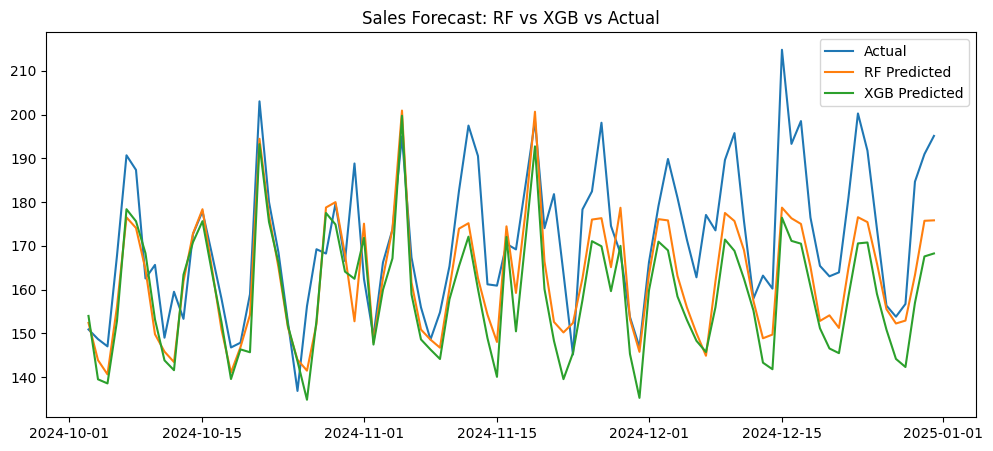

In [64]:
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_rf, label='RF Predicted')
plt.plot(y_test.index, y_pred_xgb, label='XGB Predicted')
plt.legend()
plt.title('Sales Forecast: RF vs XGB vs Actual')

# save first, then show
plt.savefig("../images/rf_vs_xgb_forecast.png", dpi=300, bbox_inches="tight")
plt.show()


### Notes
- Tune (p,d,q)(P,D,Q,7) via grid search or AIC if needed.
- Optional: Try Prophet (install `prophet`) and compare RMSE/MAPE.